In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2022-11-27 17:10:53.905952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 17:10:54.487240: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-27 17:10:54.487295: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-27 17:10:54.487300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT librar

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

import jax
import jax.numpy as jnp
import neural_tangents as nt
from jax.example_libraries import stax as ostax
from flax.training.checkpoints import restore_checkpoint

import tensorflow_datasets as tfds

In [3]:
np.random.seed(42)

In [4]:
NUM_CLASSES = 10
SEED = 42

In [5]:
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train[:80%]', 'train[80%:]'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    # label = 1 if label % 2 == 0 else 0
    label = int(label)
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        y = np.eye(NUM_CLASSES)[y]
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [6]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(48000, 784) (12000, 784) (48000, 10) (12000, 10)


In [8]:
train_length = 20000
test_length = 10000
inds = np.random.randint(0, train_x.shape[0], train_length)
train_x = train_x[inds]
train_y = train_y[inds]
inds = np.random.randint(0, test_x.shape[0], test_length)
test_x = test_x[inds]
test_y = test_y[inds]

test_x_copy = test_x.copy()

In [50]:
def adv(channels, ckpt_dir, num_iter=10, epsilon=1e-3, plot=True):

    init_fn, apply_fn = ostax.serial(
        ostax.Dense(channels),
        ostax.Relu,
        ostax.Dense(NUM_CLASSES)
    )
    
    _, init_params = init_fn(jax.random.PRNGKey(seed=SEED), (-1, 28*28))

    params = restore_checkpoint(ckpt_dir, target=init_params)

    @jax.jit
    def loss_fn(params, test_x, test_y):
        pred = apply_fn(params, test_x)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    @jax.jit
    def evaluate(params, test_x, test_y):
        pred = apply_fn(params, test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    @jax.jit
    def update(params, test_x, test_y):
        grad = jax.grad(loss_fn, argnums=1)(params, test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(params, x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x = update(params, x, test_y)
        _, acc = evaluate(params, x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(params, x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    return acc_list

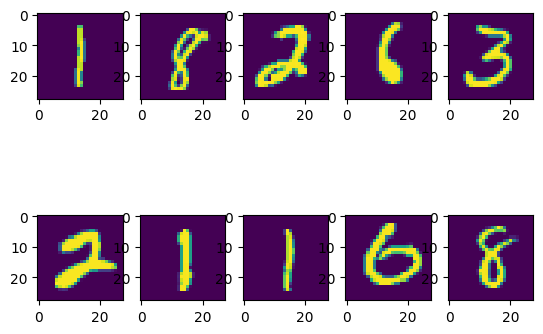

100%|██████████| 10/10 [00:00<00:00, 164.27it/s]


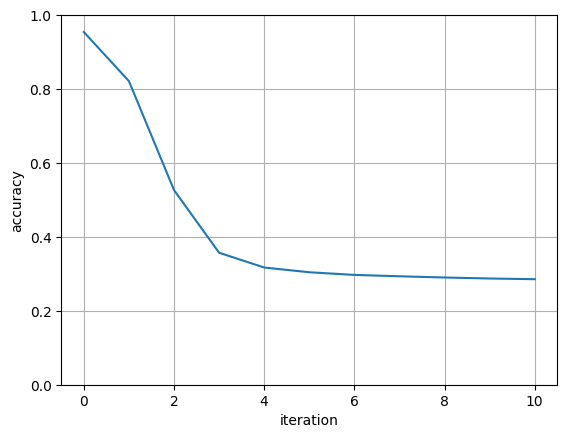

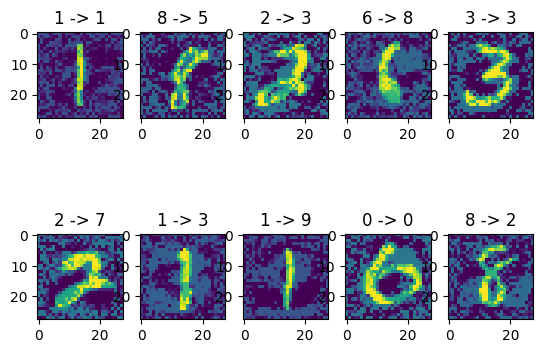

Accuracy: 0.9541999697685242 -> 0.2854999899864197


In [52]:
channels = 256
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_256 = adv(channels, ckpt_dir, epsilon=3e-3)

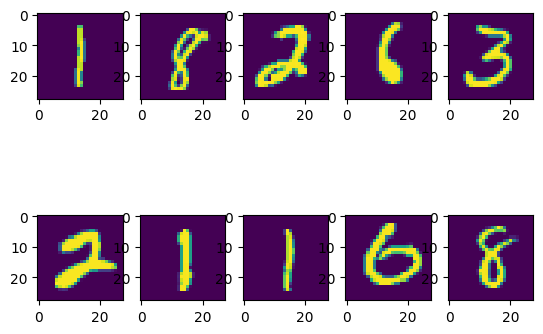

100%|██████████| 10/10 [00:00<00:00, 161.28it/s]


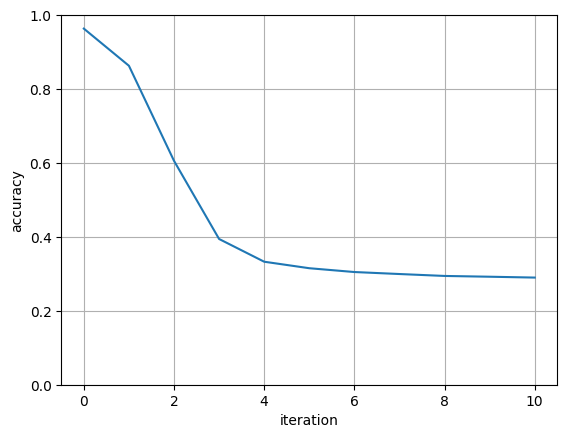

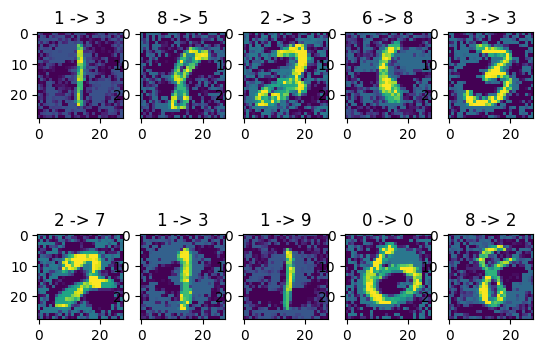

Accuracy: 0.9634999632835388 -> 0.289900004863739


In [53]:
channels = 1024
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_1024 = adv(channels, ckpt_dir, epsilon=3e-3)

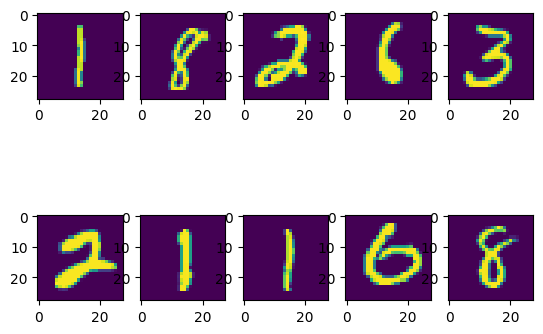

100%|██████████| 10/10 [00:00<00:00, 144.26it/s]


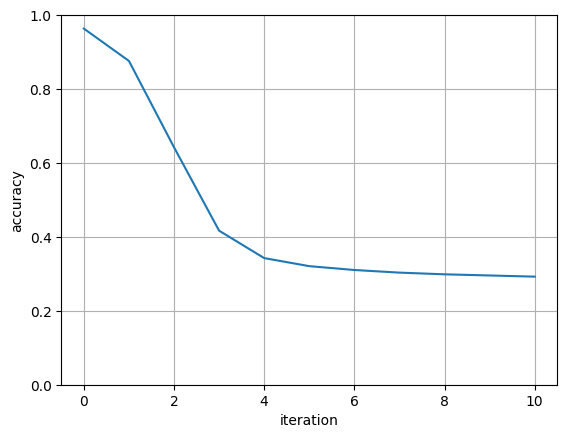

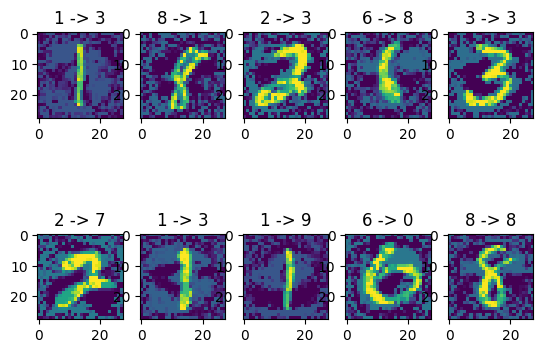

Accuracy: 0.9635999798774719 -> 0.2924000024795532


In [54]:
channels = 2048
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_2048 = adv(channels, ckpt_dir, epsilon=3e-3)

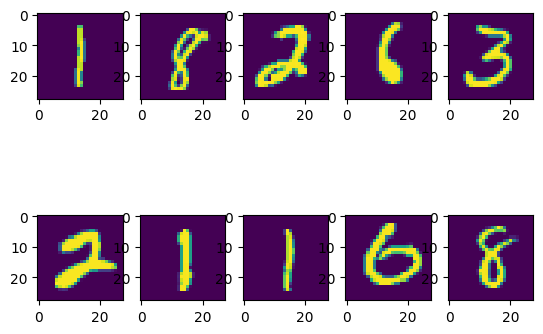

100%|██████████| 10/10 [00:00<00:00, 112.61it/s]


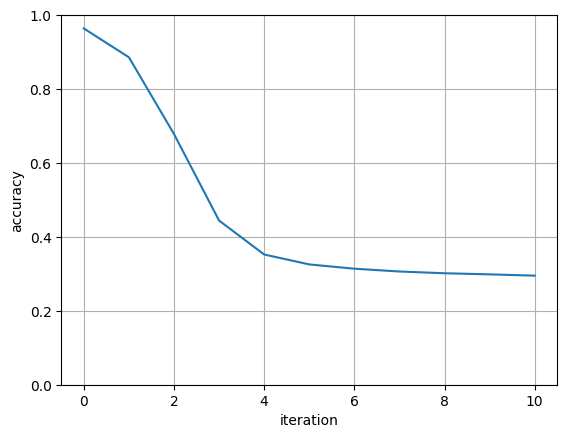

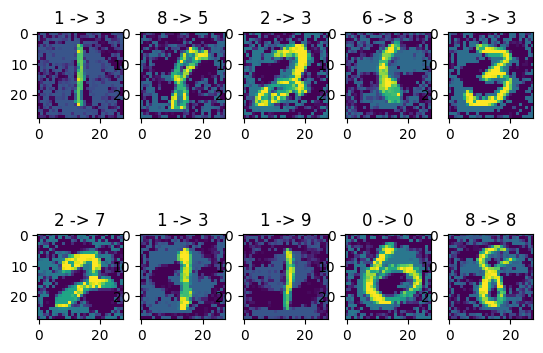

Accuracy: 0.9638999700546265 -> 0.29510000348091125


In [55]:
channels = 4096
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_4096 = adv(channels, ckpt_dir, epsilon=3e-3)

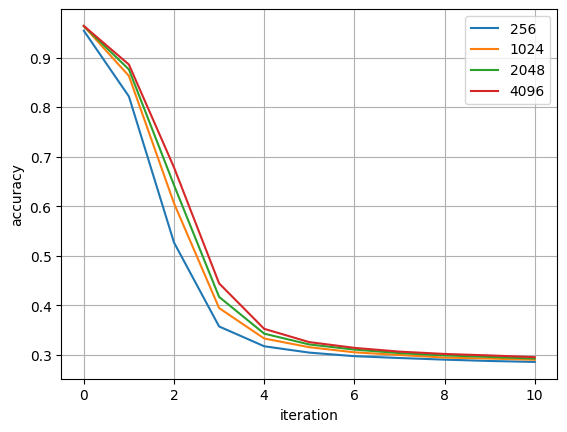

In [56]:
plt.plot(acc_list_256, label='256')
plt.plot(acc_list_1024, label='1024')
plt.plot(acc_list_2048, label='2048')
plt.plot(acc_list_4096, label='4096')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()